<a href="https://colab.research.google.com/github/AimjGuytidy/WQU-Thesis/blob/main/NBEATS_Keras1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%pip install nbeats-keras

In [6]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

from nbeats_keras.model import NBeatsNet

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [8]:
df = pd.read_csv('/content/oil.csv')
print(df.head())
print(len(df))

           Date  Price
0  Aug 25, 2017  47.65
1  Aug 28, 2017  46.40
2  Aug 29, 2017  46.46
3  Aug 30, 2017  45.96
4  Aug 31, 2017  47.26
1005


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Price
0,2017-08-25,47.65
1,2017-08-28,46.40
2,2017-08-29,46.46
3,2017-08-30,45.96
4,2017-08-31,47.26


In [10]:
df.values.flatten()

array([Timestamp('2017-08-25 00:00:00'), 47.65,
       Timestamp('2017-08-28 00:00:00'), ..., 68.84,
       Timestamp('2021-08-30 00:00:00'), 69.28], dtype=object)

In [11]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data.reshape(data.shape[0], data.shape[1], 1), labels.reshape(labels.shape[0], 1, 1)

In [12]:
class DataNormalizer:

    def __init__(self, train):
        self.uni_train_mean = train.mean()
        self.uni_train_std = train.std()

    def apply(self, x):
        return (x - self.uni_train_mean) / self.uni_train_std

    def apply_inv(self, x):
        return x * self.uni_train_std + self.uni_train_mean

In [13]:
TRAIN_SPLIT = 805

uni_data = df['Price']
uni_data.index = df['Date']

uni_data = uni_data.values

In [14]:
uni_data

array([47.65, 46.4 , 46.46, ..., 67.42, 68.84, 69.28])

In [15]:
dn = DataNormalizer(train=uni_data[:TRAIN_SPLIT])
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = dn.apply(uni_data)

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print('x_train_uni.shape=', x_train_uni.shape)
print('y_train_uni.shape=', y_train_uni.shape)
print('x_val_uni.shape=', x_val_uni.shape)
print('y_val_uni.shape=', y_val_uni.shape)

x_train_uni.shape= (785, 20, 1)
y_train_uni.shape= (785, 1, 1)
x_val_uni.shape= (180, 20, 1)
y_val_uni.shape= (180, 1, 1)


In [16]:
b_val_uni = np.mean(x_val_uni, axis=1)[..., 0]
print(np.mean(np.abs(b_val_uni - y_val_uni)))
print(np.mean(np.abs(dn.apply_inv(b_val_uni) - dn.apply_inv(y_val_uni))))

0.70700408120963
9.16352061728395


In [17]:
b2_val_uni = x_val_uni[:, -1, 0]
print(np.mean(np.abs(b2_val_uni - y_val_uni)))
print(np.mean(np.abs(dn.apply_inv(b2_val_uni) - dn.apply_inv(y_val_uni))))

0.6721394137540546
8.711637654320988


In [18]:
m = NBeatsNet(
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    nb_blocks_per_stack=3,
    forecast_length=1,
    backcast_length=univariate_past_history,
    thetas_dim=(15, 15, 15),
    share_weights_in_stack=False,
    hidden_layer_units=384)
m.compile(loss='mse', optimizer='adam')

In [34]:
class EvaluateModelCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        b3_val_uni = m.predict(x_val_uni)
        print(f'[{epoch}] b3_val_uni.shape=', b3_val_uni.shape)
        print(np.mean(np.abs(b3_val_uni - y_val_uni)))
        print(np.mean(np.abs(dn.apply_inv(b3_val_uni) - dn.apply_inv(y_val_uni))))
        print(f'MAPE:{np.mean(np.abs((dn.apply_inv(b3_val_uni) - dn.apply_inv(y_val_uni))/dn.apply_inv(y_val_uni)))}')
        print(f'RMSE:{np.sqrt(np.mean(np.square(dn.apply_inv(b3_val_uni) - dn.apply_inv(y_val_uni))))}')
        print('*' * 80)

In [35]:
tf.random.set_seed(42)
m.fit(x_train_uni, y_train_uni,
      epochs=20, validation_split=0.1, shuffle=True,
      callbacks=[EvaluateModelCallback()])

Epoch 1/20
23/23 [==============================] - 2s 57ms/step - loss: 0.0361 - val_loss: 0.0096
[0] b3_val_uni.shape= (180, 1, 1)
0.08531408754036436
1.105760462443034
MAPE:0.017564733659554344
RMSE:1.4886134725861082
********************************************************************************
Epoch 2/20
23/23 [==============================] - 1s 48ms/step - loss: 0.0330 - val_loss: 0.0093
[1] b3_val_uni.shape= (180, 1, 1)
0.07917447443664564
1.026185140821669
MAPE:0.01635338638377596
RMSE:1.386816967258987
********************************************************************************
Epoch 3/20
23/23 [==============================] - 1s 50ms/step - loss: 0.0348 - val_loss: 0.0330
[2] b3_val_uni.shape= (180, 1, 1)
0.08178702644530644
1.0600464731852215
MAPE:0.01697680458092659
RMSE:1.361582729394261
********************************************************************************
Epoch 4/20
23/23 [==============================] - 1s 48ms/step - loss: 0.0405 - val_loss: 0.010

In [31]:
0.0141**0.5

0.11874342087037917

In [ ]:
m.forecast_length

1

In [21]:
prediction = m.predict(x_val_uni).flatten()

In [22]:
true_val = y_val_uni.flatten()

In [23]:
from sklearn.metrics import r2_score

In [24]:
r2_score(true_val,prediction)

0.96817177630108

In [ ]:
k = dn.apply_inv(true_val)
k

array([46.59, 47.02, 47.58, 47.86, 48.34, 49.04, 47.79, 47.02, 47.94,
       48.18, 47.5 , 47.85, 48.24, 48.35, 47.47, 49.78, 50.45, 50.63,
       52.14, 52.15, 53.08, 52.81, 53.47, 52.25, 52.87, 53.16, 53.  ,
       52.28, 52.78, 52.61, 52.81, 52.26, 52.16, 53.55, 54.77, 55.67,
       56.19, 56.8 , 57.95, 58.34, 58.69, 58.22, 59.5 , 60.07, 61.09,
       60.4 , 59.12, 61.67, 61.66, 63.21, 63.43, 61.55, 60.54, 59.7 ,
       61.33, 63.81, 66.08, 65.03, 64.02, 64.45, 66.02, 65.59, 65.36,
       64.82, 64.55, 59.95, 61.43, 61.48, 57.75, 61.12, 58.47, 60.93,
       61.49, 60.55, 59.19, 61.41, 58.73, 59.34, 59.77, 59.61, 59.29,
       59.7 , 60.2 , 63.15, 63.42, 63.16, 63.33, 62.61, 61.34, 61.45,
       62.18, 62.02, 63.03, 63.81, 65.  , 63.5 , 64.46, 65.72, 65.63,
       64.73, 64.96, 64.92, 65.31, 65.96, 63.82, 65.32, 66.24, 65.49,
       63.28, 61.95, 63.61, 66.13, 66.27, 66.41, 66.87, 66.31, 67.8 ,
       68.79, 68.81, 69.57, 69.21, 70.11, 69.9 , 70.34, 71.  , 70.94,
       72.06, 72.03,

In [ ]:
j = dn.apply_inv(prediction)
j

array([46.718735, 46.769672, 47.058426, 47.572334, 48.12935 , 48.340652,
       48.710785, 48.21961 , 47.845856, 48.25618 , 48.565395, 48.255173,
       48.35683 , 48.5735  , 48.88618 , 48.327194, 49.488503, 50.172794,
       50.57487 , 51.488766, 51.787556, 52.316048, 52.706238, 52.944794,
       52.811882, 53.019672, 52.926723, 53.212914, 52.746155, 53.093803,
       53.181705, 53.263287, 52.81954 , 52.667286, 53.92825 , 54.82098 ,
       55.471333, 56.062206, 56.718014, 57.690414, 58.14055 , 58.39796 ,
       58.256657, 58.922054, 59.560608, 60.286358, 60.060104, 59.663593,
       60.8704  , 61.643463, 62.422928, 62.996136, 62.199215, 61.04477 ,
       60.299934, 61.2797  , 63.51421 , 65.26537 , 65.05855 , 64.419525,
       64.49851 , 65.873535, 65.79566 , 65.95643 , 65.537155, 64.94952 ,
       61.345737, 61.949806, 62.12728 , 59.354397, 61.40971 , 59.853935,
       60.21325 , 61.422516, 61.67184 , 60.654964, 61.90306 , 60.332638,
       59.921497, 60.16074 , 59.677197, 59.475986, 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

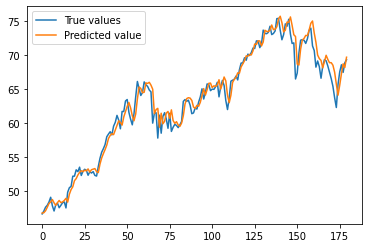

In [ ]:
plt.plot(k,label='True values')
plt.plot(j,label='Predicted value')
plt.legend()
plt.show()

In [ ]:
y_val_uni.shape

(180, 1, 1)

In [ ]:
ts = pd.read_csv('/content/predict.csv',index_col=0,parse_dates=True)
ts.head()

,Prices
Date,
2021-08-31,68.43
2021-09-01,68.63
2021-09-02,70.07
2021-09-03,69.34
2021-09-07,68.49


In [ ]:
ts_norm = dn.apply(ts.values)
ts_norm

array([[1.10792182],
       [1.12335266],
       [1.2344547 ],
       [1.17813214],
       [1.11255107],
       [1.17967522],
       [1.09480561],
       [1.21516615],
       [1.27071718],
       [1.26994563],
       [1.42888328],
       [1.4365987 ],
       [1.39030618],
       [1.26068713],
       [1.26840255],
       [1.41190936],
       [1.49369281],
       [1.55155846],
       [1.65648816],
       [1.64877274],
       [1.61945415],
       [1.63179882],
       [1.69275064],
       [1.82159815]])

In [ ]:
ts_norm.shape

(24, 1)

In [ ]:
pd.DataFrame(tf.squeeze(dn.apply_inv(x_train_uni)).numpy()).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,47.65,46.40,46.46,45.96,47.26,47.32,48.63,49.13,49.10,47.44,48.06,48.21,49.30,49.86,49.90,49.88,49.54,50.29,50.58,50.33
1,46.40,46.46,45.96,47.26,47.32,48.63,49.13,49.10,47.44,48.06,48.21,49.30,49.86,49.90,49.88,49.54,50.29,50.58,50.33,51.85
2,46.46,45.96,47.26,47.32,48.63,49.13,49.10,47.44,48.06,48.21,49.30,49.86,49.90,49.88,49.54,50.29,50.58,50.33,51.85,51.59
3,45.96,47.26,47.32,48.63,49.13,49.10,47.44,48.06,48.21,49.30,49.86,49.90,49.88,49.54,50.29,50.58,50.33,51.85,51.59,52.14
4,47.26,47.32,48.63,49.13,49.10,47.44,48.06,48.21,49.30,49.86,49.90,49.88,49.54,50.29,50.58,50.33,51.85,51.59,52.14,51.62


In [ ]:
pd.DataFrame(tf.squeeze(dn.apply_inv(y_train_uni)).numpy()).head()

,0
0,51.85
1,51.59
2,52.14
3,51.62
4,51.67


In [ ]:
test_val = ts_norm[:20]

In [ ]:
test_val_exp = tf.expand_dims(test_val,axis=0).numpy()
test_val_exp

array([[[1.10792182],
        [1.12335266],
        [1.2344547 ],
        [1.17813214],
        [1.11255107],
        [1.17967522],
        [1.09480561],
        [1.21516615],
        [1.27071718],
        [1.26994563],
        [1.42888328],
        [1.4365987 ],
        [1.39030618],
        [1.26068713],
        [1.26840255],
        [1.41190936],
        [1.49369281],
        [1.55155846],
        [1.65648816],
        [1.64877274]]])

In [ ]:
pred_val = m.predict(test_val_exp)

In [ ]:
pred_inv = dn.apply_inv(pred_val)
print(f'the predicted price for september 29th is:{pred_inv[0][0][0]}')

the predicted price for september 29th is:75.57968139648438


In [ ]:
ts.iloc[20,:]

Prices    75.06
Name: 2021-09-29 00:00:00, dtype: float64

In [ ]:
# m.save('/content/drive/MyDrive/nbeats_model.h5')